In [1]:
import geopandas as gpd
import geojsonio as geoio
import pandas as pd
from collections import defaultdict
from shapely.geometry import Point, Polygon
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Read Data

In [2]:
vancouver_all_data = gpd.read_file('VancouverAllData.geojson')
vancouver_gdf = gpd.GeoDataFrame({'population':vancouver_all_data['pop'], 'geometry':vancouver_all_data['geometry']})
vancouver_gdf = vancouver_gdf.reset_index()
vancouver_gdf['population'] = pd.to_numeric(vancouver_gdf['population'])

osm_data = pd.read_json('osm/amenities-vancouver.json.gz', lines=True, compression='gzip')
osm_data['geometry'] = list(zip(osm_data['lon'],osm_data['lat']))
osm_data['geometry'] = osm_data['geometry'].apply(Point)
osm_gdf = gpd.GeoDataFrame({'amenity':osm_data['amenity'], 'geometry':osm_data['geometry']}, geometry='geometry', crs=vancouver_gdf.crs)
vancouver_gdf['area'] = vancouver_gdf['geometry'].area
vancouver_gdf['population_density'] = vancouver_gdf['population'] / (vancouver_gdf['area'] * 1000)
vancouver_gdf

/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_7794/153644771.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vancouver_gdf['area'] = vancouver_gdf['geometry'].area


,index,population,geometry,area,population_density
0,0,6154,"MULTIPOLYGON (((-123.02353 49.20818, -123.0235...",0.000126,48910.333782
1,1,8245,"MULTIPOLYGON (((-123.02353 49.20818, -123.0234...",0.000229,35926.018931
2,2,6949,"MULTIPOLYGON (((-123.04245 49.20549, -123.0426...",0.000239,29018.934041
3,3,3908,"MULTIPOLYGON (((-123.05918 49.21162, -123.0597...",0.000097,40318.042652
4,4,4527,"MULTIPOLYGON (((-123.05918 49.21162, -123.0587...",0.000095,47558.899022
...,...,...,...,...,...
484,484,3530,"MULTIPOLYGON (((-122.57911 49.17246, -122.5788...",0.000646,5462.802541
485,485,96,"MULTIPOLYGON (((-122.56953 49.17974, -122.5694...",0.000216,445.127637
486,486,6228,"MULTIPOLYGON (((-122.46134 49.16769, -122.4613...",0.007359,846.345399
487,487,4255,"MULTIPOLYGON (((-122.45998 49.07500, -122.4598...",0.000378,11259.178637


In [3]:
# we did this to verify that .explode and .area compute the same area 
# vancouver_gdf_explode = vancouver_gdf.explode('geometry')
# vancouver_gdf_explode['area'] = vancouver_gdf_explode['geometry'].area
# vancouver_gdf_explode
# vancouver_gdf.max()

# Data Prep

In [4]:
# use spatial join to match points (osm data) and multipolygons (vancouver data)
pointInPolys = gpd.tools.sjoin(osm_gdf, vancouver_gdf, op="within", how='left')
# index_right is the index of the joined multipolygon, i.e. ID of an area
# group by area and for each area, get the list of amenities located in this area
amenitiesInEachArea = pointInPolys.groupby(['index_right'])['amenity'].apply(list)
# count the number of each amenity in the area and put it into dict
amenitiesInEachArea = amenitiesInEachArea.apply(lambda x: Counter(x))
amenitiesInEachArea
vancouver_gdf['amenities'] = amenitiesInEachArea
# split the dict column into separate columns
vancouver_gdf = pd.concat([vancouver_gdf.drop(['amenities'], axis=1), vancouver_gdf['amenities'].apply(pd.Series)], axis=1)
# some columns are duplicated for some reason??? (removed duplciates based on col names but need to make sure we're not dropping useful data)
vancouver_gdf = vancouver_gdf.loc[:,~vancouver_gdf.columns.duplicated()].drop([0, 'index'], axis=1).fillna(0)

vancouver_gdf

/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,population,geometry,area,population_density,shelter,post_box,bank,fast_food,restaurant,bench,...,hunting_stand,waste_transfer_station,vacuum_cleaner,lounge,EVSE,storage_rental,atm;bank,healthcare,stripclub,money_transfer
0,6154,"MULTIPOLYGON (((-123.02353 49.20818, -123.0235...",0.000126,48910.333782,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8245,"MULTIPOLYGON (((-123.02353 49.20818, -123.0234...",0.000229,35926.018931,1.0,1.0,5.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6949,"MULTIPOLYGON (((-123.04245 49.20549, -123.0426...",0.000239,29018.934041,0.0,1.0,0.0,0.0,1.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3908,"MULTIPOLYGON (((-123.05918 49.21162, -123.0597...",0.000097,40318.042652,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4527,"MULTIPOLYGON (((-123.05918 49.21162, -123.0587...",0.000095,47558.899022,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,3530,"MULTIPOLYGON (((-122.57911 49.17246, -122.5788...",0.000646,5462.802541,1.0,0.0,0.0,1.0,12.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,96,"MULTIPOLYGON (((-122.56953 49.17974, -122.5694...",0.000216,445.127637,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
486,6228,"MULTIPOLYGON (((-122.46134 49.16769, -122.4613...",0.007359,846.345399,0.0,1.0,0.0,3.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487,4255,"MULTIPOLYGON (((-122.45998 49.07500, -122.4598...",0.000378,11259.178637,0.0,0.0,0.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Scale data accroding to the amenities scoring

0.1638128373048855


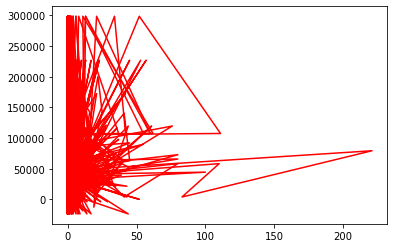

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


X = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density'], axis=1).values
y = vancouver_gdf['population_density'].values # divide by the area of the multipolygon 
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# train model
model = make_pipeline(
        StandardScaler(),
        PCA(40),
        PolynomialFeatures(degree=1, include_bias=True),
        LinearRegression(fit_intercept=False)
)

model.fit(X_train, y_train)
# validate model
# check r^2 instead of .score
print(model.score(X_valid, y_valid))
predicted_y = model.predict(vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density'], axis=1).values)
plt.plot(X, predicted_y, '-r')


Make a residual plot

Used predicted y label and the original y label to compute the percentage difference and produce the heatmap based on it


In [6]:
vancouver_gdf['predicted_population_density_difference'] = vancouver_gdf["population_density"] - predicted_y
vancouver_gdf['percentage_difference'] = (vancouver_gdf['predicted_population_density_difference'] / vancouver_gdf['population_density']) * 100

def getColorFromPercentage(percentage):
    if percentage < -80:
        return '#8b7efd'
    elif percentage < -60:
        return '#a89bff'
    elif percentage < -40:
        return '#c3b9ff'
    elif percentage < -20:
        return '#ddd7ff'
    elif percentage < 0:
        return '#e4d4fe'
    elif percentage > 80:
        return '#ff3d61'
    elif percentage > 60:
        return '#ff73a6'
    elif percentage > 40:
        return '#ffa4da'
    elif percentage > 20:
        return '#f4cff8'
    elif percentage >= 0:
        return '#ecd2fc'

vancouver_gdf["amenity_count"] = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference'], axis=1).sum(axis=1)
vancouver_gdf['fill'] = vancouver_gdf['percentage_difference'].apply(lambda percentage: getColorFromPercentage(percentage))
heatmap_gdf = gpd.GeoDataFrame({'geometry':vancouver_gdf['geometry'], 'fill':vancouver_gdf['fill'], 'pop_dens': vancouver_gdf['population_density'], 'amenity_count': vancouver_gdf['amenity_count']})
heatmap_gdf
heatmap_gdf.to_file('heatmap.geojson', driver="GeoJSON")
contents = gpd.read_file('heatmap.geojson')
geoio.display(contents)


/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


'http://geojson.io/#id=gist:/ef3cbe95f6343ba6b9e73e702487f5c3'

In [7]:
red_areas = vancouver_gdf[vancouver_gdf['percentage_difference'] > 0]
blue_areas = vancouver_gdf[vancouver_gdf['percentage_difference'] <= 0]
red_areas


,population,geometry,area,population_density,shelter,post_box,bank,fast_food,restaurant,bench,...,EVSE,storage_rental,atm;bank,healthcare,stripclub,money_transfer,predicted_population_density_difference,percentage_difference,amenity_count,fill
0,6154,"MULTIPOLYGON (((-123.02353 49.20818, -123.0235...",0.000126,48910.333782,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14267.198484,29.170111,0.0,#f4cff8
1,8245,"MULTIPOLYGON (((-123.02353 49.20818, -123.0234...",0.000229,35926.018931,1.0,1.0,5.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3465.518616,9.646264,19.0,#ecd2fc
3,3908,"MULTIPOLYGON (((-123.05918 49.21162, -123.0597...",0.000097,40318.042652,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11209.994246,27.803915,4.0,#f4cff8
4,4527,"MULTIPOLYGON (((-123.05918 49.21162, -123.0587...",0.000095,47558.899022,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8819.131357,18.543599,3.0,#ecd2fc
5,3703,"MULTIPOLYGON (((-123.07203 49.21459, -123.0727...",0.000067,55275.867375,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,26833.531926,48.544751,6.0,#ffa4da
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,4363,"MULTIPOLYGON (((-122.84719 49.20023, -122.8468...",0.000090,48720.897130,0.0,4.0,2.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19424.842799,39.869633,34.0,#f4cff8
466,5317,"MULTIPOLYGON (((-122.65995 49.09549, -122.6601...",0.000072,73565.945990,0.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,52302.310448,71.095817,21.0,#ff73a6
467,5125,"MULTIPOLYGON (((-122.64681 49.10222, -122.6468...",0.000104,49215.154677,0.0,2.0,0.0,5.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5293.809653,10.756462,43.0,#ecd2fc
471,3183,"MULTIPOLYGON (((-122.63283 49.16229, -122.6334...",0.000104,30593.479092,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2063.492250,6.744876,8.0,#ecd2fc


Now we find what amenities are important in red areas and in blue areas

In [8]:
red_areas_amenities = red_areas.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference', 'amenity_count'], axis=1)
red_areas_amenities_avg = red_areas_amenities.mean().sort_values(ascending=False)

blue_areas_amenities = blue_areas.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference', 'amenity_count'], axis=1)
blue_areas_amenities_avg = blue_areas_amenities.mean().sort_values(ascending=False)

red_and_blue_avg = pd.concat([red_areas_amenities_avg, blue_areas_amenities_avg], axis=1).rename({0: 'red_avg', 1:'blue_avg'}, axis=1)
red_and_blue_avg


/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_7794/3895382976.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  red_areas_amenities_avg = red_areas_amenities.mean().sort_values(ascending=False)
/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_7794/3895382976.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  blue_areas_amenities_avg = blue_areas_amenities.mean().sort_values(ascending=False)


,red_avg,blue_avg
bench,6.700000,6.110368
restaurant,4.842105,4.401338
bicycle_parking,2.578947,2.872910
cafe,2.047368,1.926421
fast_food,1.805263,2.063545
...,...,...
courthouse,0.000000,0.006689
chiropractor,0.000000,0.003344
Observation Platform,0.000000,0.003344
Pharmacy,0.000000,0.006689


we did the T-test on whether the avg num of amenities in red differ from the avg num of amenities in blue since the var is ar close

we then confirmed the result using mannwhitneyu

In [9]:
red_and_blue_avg = red_and_blue_avg.dropna()

from scipy import stats
print(stats.normaltest(red_and_blue_avg['red_avg']).pvalue)
print(stats.levene(red_and_blue_avg['red_avg'], red_and_blue_avg['blue_avg']).pvalue)

ttest = stats.ttest_ind(red_and_blue_avg['red_avg'], red_and_blue_avg['blue_avg'])
print(ttest)
print(ttest.statistic)
print(ttest.pvalue)

print(stats.mannwhitneyu(red_and_blue_avg['red_avg'], red_and_blue_avg['blue_avg']).pvalue)


3.943461458784109e-39
0.9772419959440983
Ttest_indResult(statistic=0.05129561080677942, pvalue=0.9591322800345209)
0.05129561080677942
0.9591322800345209
0.34784671038886805


Since p-value is high, we failed to reject H0 (which is red= blue), and we conclude that the avg num of amenities in red differ from the avg num of amenities in blue

number of amenities and population density of the area are slightly positvely correlated

In [10]:
red_areas['amenity_count'].corr(red_areas['population_density'])

0.2893677269097492

In [11]:
red_areas_amenities = red_areas_amenities.drop(['fill'], axis=1)
correlations = {}
for col in red_areas_amenities:
    # print(red_areas_amenities[col], red_areas['population_density'])
    correlations[col] = red_areas_amenities[col].corr(red_areas['population_density'])
correlations = dict(sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True))
correlations


{'motorcycle_rental': nan,
 'Pharmacy': nan,
 'car_sharing': 0.5630155915039862,
 'bicycle_rental': 0.5559796984850109,
 'restaurant': 0.37561493324848577,
 'cafe': 0.36762648473398774,
 'post_box': 0.28348619178873624,
 'bicycle_parking': 0.28347798341483166,
 'bar': 0.2639409320851452,
 'post_office': 0.2492262532718588,
 'pub': 0.23280359983828286,
 'bench': 0.20796810238683958,
 'fuel': -0.20693543317261717,
 'fast_food': 0.19899422969768624,
 'pharmacy': 0.19118923978416114,
 'toilets': -0.1853000915400104,
 'shelter': -0.18478414674353122,
 'clinic': 0.17330370923573288,
 'vending_machine': -0.16600908656154986,
 'place_of_worship': -0.16364622317319974,
 'bank': 0.1609215935174754,
 'dentist': 0.15771152567649832,
 'ice_cream': 0.1501065990481648,
 'marketplace': 0.14337234280130448,
 'car_rental': 0.14322367392723254,
 'community_centre': 0.14026433483500736,
 'language_school': 0.10248033238081163,
 'telephone': -0.10036940066171847,
 'theatre': 0.09013324194098288,
 'hospital

TODO: Pharmacy vs pharmacy
make everything lower case

Car sharing is sur

# Machine Learning

Our x is the number of amenities of some type in the area (e.g. 2 cafes, 4 banks, etc.). Our y is the population density in this area.<br>
TO DO: Did we want to manually calculate a score for each area and use it as training data?

# Analysis

since our model sucks, we decided to do t-test and confirm that the two vars are not related

TO DO: among the red areas, which amenity is the most important?